In [1]:
import os
import re
import sys
import gzip
import json
import codecs
import pyBigWig
import numpy as np
from pyfaidx import Fasta
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
%matplotlib inline

In [2]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
allFlanks = []
with open("../data/experimental/all_scaled_nn_preds.txt") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank,protein,_,_,_,ddG,_ = line.strip().split('\t')
        if protein == "Cbf1": flankToCbf1Ddg[flank] = float(ddG)
        else: flankToPho4Ddg[flank] = float(ddG)
        allFlanks.append(flank)
allFlanks = list(set(allFlanks))

In [3]:
tfToBigWigs = {}
tfToBigWigs["pho4_pbexo"] = (pyBigWig.open("../data/pho4_pbexo/basename_prefix.pooled.positive.bigwig"),
                             pyBigWig.open("../data/pho4_pbexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["cbf1_pbexo"] = (pyBigWig.open("../data/cbf1_pbexo/basename_prefix.pooled.positive.bigwig"),
                             pyBigWig.open("../data/cbf1_pbexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["pho4_120m"] = (pyBigWig.open("../data/nexus/120min/sc_myc_PHO4_120min_nexus_1_positive.bw"),
                            pyBigWig.open("../data/nexus/120min/sc_myc_PHO4_120min_nexus_1_negative.bw"))
tfToBigWigs["cbf1_nexus"] = (pyBigWig.open("../data/cbf1_nexus/pos.bw"),
                             pyBigWig.open("../data/cbf1_nexus/neg.bw"))

In [4]:
tfToBeds = {}
tfToBeds["pho4_pbexo"] = open("../data/pho4_pbexo/pho4.pbexo.bed")
tfToBeds["cbf1_pbexo"] = open("../data/cbf1_pbexo/cbf1.pbexo.bed")
tfToBeds["pho4_120m"] = open("../data/nexus/120min/sc_myc_PHO4_120min_nexus_1_peaks.narrowPeak")
tfToBeds["cbf1_nexus"] = open("../data/cbf1_nexus/overlap.peaks.bed")

In [5]:
chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

fastapath = "../data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [6]:
motif = "CACGTG"
motifLen = len(motif)
flankLen = 5
genomeFlankToCoord = {}
for chrm in chrms:
    sequence = GenomeDict[chrm].upper()
    for m in re.finditer(motif, sequence):
        flank = GenomeDict[chrm][m.start()-flankLen:m.start()]+ \
                GenomeDict[chrm][m.start()+motifLen:m.start()+motifLen+flankLen]
        if flank not in genomeFlankToCoord:
            genomeFlankToCoord[flank] = []
        genomeFlankToCoord[flank].append((chrm, m.start()+(motifLen/2)))

In [7]:
seq_len = 546
keyToFlankToCoord = {}
keyToFlankToCoord["pho4_pbexo"] = {}
keyToFlankToCoord["cbf1_pbexo"] = {}
keyToFlankToCoord["pho4_120m"] = {}
keyToFlankToCoord["cbf1_nexus"] = {}
for key in tfToBeds:
    for line in tfToBeds[key]:
        peakChrm = line.strip().split('\t')[0]
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        for flank in genomeFlankToCoord:
            for chrm, center in genomeFlankToCoord[flank]:
                if chrm == peakChrm and center >= start and center <= end:
                    if flank not in keyToFlankToCoord[key]:
                        keyToFlankToCoord[key][flank] = []
                    keyToFlankToCoord[key][flank].append((chrm, center))

In [8]:
seq_len = 546
posFootprint = {}
negFootprint = {}
for key in tfToBigWigs.keys():
    posFootprint[key] = {}
    negFootprint[key] = {}
    for flank in keyToFlankToCoord[key]:
        currentPosCounts= []
        currentNegCounts = []
        for chrm, center in keyToFlankToCoord[key][flank]: 
            start = int(center-(seq_len/2))
            end = int(center+(seq_len/2))
            posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            currentPosCounts.append(np.abs(posvals))
            negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            currentNegCounts.append(np.abs(negvals))
        posFootprint[key][flank] = np.mean(np.array(currentPosCounts), axis = 0)
        negFootprint[key][flank] = np.mean(np.array(currentNegCounts), axis = 0)

pho4_pbexo


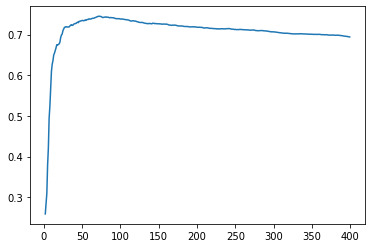

cbf1_pbexo


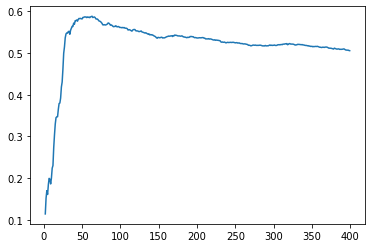

pho4_120m


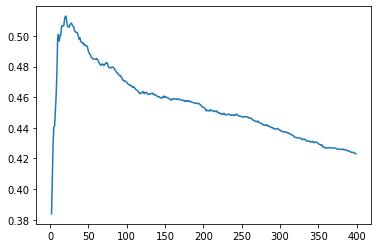

cbf1_nexus


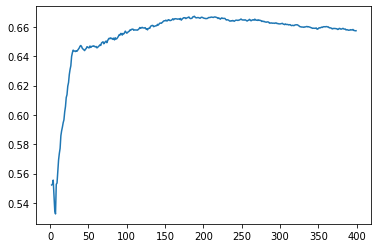

In [9]:
keyToBestWindow = {}
keyToXVals = {}
keyToYVals = {}

for key in tfToBigWigs.keys():
    print(key)
    xvals_pho4 = []
    xvals_cbf1 = []
    for flank in keyToFlankToCoord[key]:
        xvals_pho4.append(flankToPho4Ddg[flank])
        xvals_cbf1.append(flankToCbf1Ddg[flank])
    if "pho4" in key:
        xvals = xvals_pho4
    elif "cbf1" in key:
        xvals = xvals_cbf1
    keyToXVals[key] = xvals
    perfs = []
    best_perf = 0.0
    for window in range(2, 400):
        start = int((seq_len/2)-(window/2))
        end = int((seq_len/2)+(window/2))
        yvals = []
        for flank in keyToFlankToCoord[key]:
            yvals.append(1+np.sum(posFootprint[key][flank][start:end]+ \
                                  negFootprint[key][flank][start:end]))
        new_perf = abs(spearmanr(xvals, yvals)[0])
        perfs.append(new_perf)
        if new_perf > best_perf:
            best_perf = new_perf
            keyToBestWindow[key] = window
            keyToYVals[key] = np.log(yvals)
    fig, ax = plt.subplots()
    ax.plot(range(2, 400), perfs)
    plt.show()

In [10]:
font = {'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

for key in tfToBigWigs.keys():
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax = fig.add_subplot(111)
    plt.scatter(keyToXVals[key], keyToYVals[key], alpha=0.35)
    meta = {}
    meta["key"] = key
    meta["x-axis"] = "ddG"
    meta["y-axis"] = "natural log of ( 1 + counts )"
    meta["best-window"] = keyToBestWindow[key]
    meta["Number of hits in peaks"] = len(keyToFlankToCoord[key])
    meta["spearman"] = spearmanr(keyToXVals[key], keyToYVals[key])[0]
    meta["pearson"] = pearsonr(keyToXVals[key], keyToYVals[key])[0]
    # Residuals is sum of squared residuals of the least-squares fit
    meta["residuals"] = np.polyfit(keyToXVals[key], keyToYVals[key], 1, full=True)[1][0]
    # ax.set_xlim((1,5.75))
    # ax.set_ylim((1,5.75))
    # ax.set_aspect('equal')
    fig.savefig(key+'_raw_counts_baseline.png', dpi=300)
    plt.clf()
    with open(key+'_raw_counts_metadata.json', 'w') as fp: json.dump(meta, fp)

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>